In [0]:
%matplotlib inline

import pickle as pkl

import matplotlib.pyplot as plt
import numpy as np
from scipy.io import loadmat
import tensorflow as tf

In [0]:
!mkdir data

In [0]:
from urllib.request import urlretrieve
from os.path import isfile, isdir
from tqdm import tqdm

data_dir = 'data/'

if not isdir(data_dir):
    raise Exception("Data directory doesn't exist!")

class DLProgress(tqdm):
    last_block = 0

    def hook(self, block_num=1, block_size=1, total_size=None):
        self.total = total_size
        self.update((block_num - self.last_block) * block_size)
        self.last_block = block_num

if not isfile(data_dir + "train_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Training Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/train_32x32.mat',
            data_dir + 'train_32x32.mat',
            pbar.hook)

if not isfile(data_dir + "test_32x32.mat"):
    with DLProgress(unit='B', unit_scale=True, miniters=1, desc='SVHN Testing Set') as pbar:
        urlretrieve(
            'http://ufldl.stanford.edu/housenumbers/test_32x32.mat',
            data_dir + 'test_32x32.mat',
            pbar.hook)

SVHN Training Set: 182MB [00:05, 33.5MB/s]                           
SVHN Testing Set: 64.3MB [00:02, 31.2MB/s]                            


In [0]:
trainset = loadmat(data_dir + 'train_32x32.mat')
testset = loadmat(data_dir + 'test_32x32.mat')

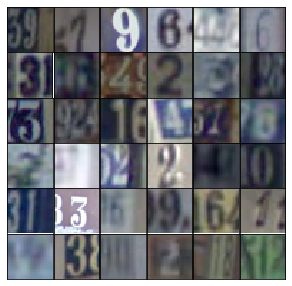

In [0]:
idx = np.random.randint(0, trainset['X'].shape[3], size=36)
fig, axes = plt.subplots(6, 6, sharex=True, sharey=True, figsize=(5,5),)
for ii, ax in zip(idx, axes.flatten()):
    ax.imshow(trainset['X'][:,:,:,ii], aspect='equal')
    ax.xaxis.set_visible(False)
    ax.yaxis.set_visible(False)
plt.subplots_adjust(wspace=0, hspace=0)

In [0]:
def scale(x, feature_range=(-1, 1)):
    # scale to (0, 1)
    x = ((x - x.min())/(255 - x.min()))
    
    # scale to feature_range
    min, max = feature_range
    x = x * (max - min) + min
    return x

In [0]:
class Dataset:
    def __init__(self, train, test, val_frac=0.5, shuffle=False, scale_func=None):
        split_idx = int(len(test['y'])*(1 - val_frac))
        self.test_x, self.valid_x = test['X'][:,:,:,:split_idx], test['X'][:,:,:,split_idx:]
        self.test_y, self.valid_y = test['y'][:split_idx], test['y'][split_idx:]
        self.train_x, self.train_y = train['X'], train['y']
        
        self.train_x = np.rollaxis(self.train_x, 3)
        self.valid_x = np.rollaxis(self.valid_x, 3)
        self.test_x = np.rollaxis(self.test_x, 3)
        
        if scale_func is None:
            self.scaler = scale
        else:
            self.scaler = scale_func
        self.shuffle = shuffle
        
    def batches(self, batch_size):
        if self.shuffle:
            idx = np.arange(len(dataset.train_x))
            np.random.shuffle(idx)
            self.train_x = self.train_x[idx]
            self.train_y = self.train_y[idx]
        
        n_batches = len(self.train_y)//batch_size
        for ii in range(0, len(self.train_y), batch_size):
            x = self.train_x[ii:ii+batch_size]
            y = self.train_y[ii:ii+batch_size]
            
            yield self.scaler(x), y

In [0]:
def model_inputs(real_dim, z_dim):
    inputs_real = tf.placeholder(tf.float32, (None, *real_dim), name='input_real')
    inputs_z = tf.placeholder(tf.float32, (None, z_dim), name='input_z')
    
    return inputs_real, inputs_z

In [0]:
def generator(z, output_dim, reuse=False, alpha=0.2, training=True):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        x1 = tf.layers.dense(z, 4*4*512)
        # Reshape it to start the convolutional stack
        x1 = tf.reshape(x1, (-1, 4, 4, 512))
        x1 = tf.layers.batch_normalization(x1, training=training)
        x1 = tf.maximum(alpha * x1, x1)
        # 4x4x512 now
        
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=2, padding='same')
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(alpha * x2, x2)
        # 8x8x256 now
        
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=2, padding='same')
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(alpha * x3, x3)
        # 16x16x128 now
        
        # Output layer
        logits = tf.layers.conv2d_transpose(x3, output_dim, 5, strides=2, padding='same')
        # 32x32x3 now
        
        out = tf.tanh(logits)
        
        return out

In [0]:
def discriminator(x, reuse=False, alpha=0.2):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Input layer is 32x32x3
        x1 = tf.layers.conv2d(x, 64, 5, strides=2, padding='same')
        relu1 = tf.maximum(alpha * x1, x1)
        # 16x16x64
        
        x2 = tf.layers.conv2d(relu1, 128, 5, strides=2, padding='same')
        bn2 = tf.layers.batch_normalization(x2, training=True)
        relu2 = tf.maximum(alpha * bn2, bn2)
        # 8x8x128
        
        x3 = tf.layers.conv2d(relu2, 256, 5, strides=2, padding='same')
        bn3 = tf.layers.batch_normalization(x3, training=True)
        relu3 = tf.maximum(alpha * bn3, bn3)
        # 4x4x256

        # Flatten it
        flat = tf.reshape(relu3, (-1, 4*4*256))
        logits = tf.layers.dense(flat, 1)
        out = tf.sigmoid(logits)
        
        return out, logits

In [0]:
def model_loss(input_real, input_z, output_dim, alpha=0.2):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    g_model = generator(input_z, output_dim, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)

    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake

    return d_loss, g_loss

In [0]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)

    return d_train_opt, g_train_opt

In [0]:
class GAN:
    def __init__(self, real_size, z_size, learning_rate, alpha=0.2, beta1=0.5):
        tf.reset_default_graph()
        
        self.input_real, self.input_z = model_inputs(real_size, z_size)
        
        self.d_loss, self.g_loss = model_loss(self.input_real, self.input_z,
                                              real_size[2], alpha=alpha)
        
        self.d_opt, self.g_opt = model_opt(self.d_loss, self.g_loss, learning_rate, beta1)

In [0]:
def view_samples(epoch, samples, nrows, ncols, figsize=(5,5)):
    fig, axes = plt.subplots(figsize=figsize, nrows=nrows, ncols=ncols, 
                             sharey=True, sharex=True)
    for ax, img in zip(axes.flatten(), samples[epoch]):
        ax.axis('off')
        img = ((img - img.min())*255 / (img.max() - img.min())).astype(np.uint8)
        ax.set_adjustable('box-forced')
        im = ax.imshow(img, aspect='equal')
   
    plt.subplots_adjust(wspace=0, hspace=0)
    return fig, axes

In [0]:
def train(net, dataset, epochs, batch_size, print_every=10, show_every=100, figsize=(5,5)):
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-1, 1, size=(72, z_size))

    samples, losses = [], []
    steps = 0

    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for e in range(epochs):
            for x, y in dataset.batches(batch_size):
                steps += 1

                # Sample random noise for G
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_size))

                # Run optimizers
                _ = sess.run(net.d_opt, feed_dict={net.input_real: x, net.input_z: batch_z})
                _ = sess.run(net.g_opt, feed_dict={net.input_z: batch_z, net.input_real: x})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = net.d_loss.eval({net.input_z: batch_z, net.input_real: x})
                    train_loss_g = net.g_loss.eval({net.input_z: batch_z})

                    print("Epoch {}/{}...".format(e+1, epochs),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    # Save losses to view after training
                    losses.append((train_loss_d, train_loss_g))

                if steps % show_every == 0:
                    gen_samples = sess.run(
                                   generator(net.input_z, 3, reuse=True, training=False),
                                   feed_dict={net.input_z: sample_z})
                    samples.append(gen_samples)
                    _ = view_samples(-1, samples, 6, 12, figsize=figsize)
                    plt.show()

        saver.save(sess, './checkpoints/generator.ckpt')

    with open('samples.pkl', 'wb') as f:
        pkl.dump(samples, f)
    
    return losses, samples

In [0]:
real_size = (32,32,3)
z_size = 100
learning_rate = 0.0002
batch_size = 128
epochs = 25
alpha = 0.2
beta1 = 0.5

# Create the network
net = GAN(real_size, z_size, learning_rate, alpha=alpha, beta1=beta1)

Instructions for updating:
Use keras.layers.dense instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.batch_normalization instead.
Instructions for updating:
Use keras.layers.conv2d_transpose instead.
Instructions for updating:
Use keras.layers.conv2d instead.


Epoch 1/25... Discriminator Loss: 1.8526... Generator Loss: 0.4667
Epoch 1/25... Discriminator Loss: 0.4883... Generator Loss: 1.4286
Epoch 1/25... Discriminator Loss: 0.1988... Generator Loss: 2.2189
Epoch 1/25... Discriminator Loss: 0.1839... Generator Loss: 2.4569
Epoch 1/25... Discriminator Loss: 0.1805... Generator Loss: 2.8467
Epoch 1/25... Discriminator Loss: 0.1456... Generator Loss: 2.5133
Epoch 1/25... Discriminator Loss: 0.1169... Generator Loss: 2.9518
Epoch 1/25... Discriminator Loss: 0.4968... Generator Loss: 1.6688
Epoch 1/25... Discriminator Loss: 0.0815... Generator Loss: 3.4416
Epoch 1/25... Discriminator Loss: 0.2420... Generator Loss: 3.2770


/usr/local/lib/python3.6/dist-packages/matplotlib/axes/_base.py:1334: MatplotlibDeprecationWarning: 
box-forced
  "2.2", "box-forced", obj_type="keyword argument")


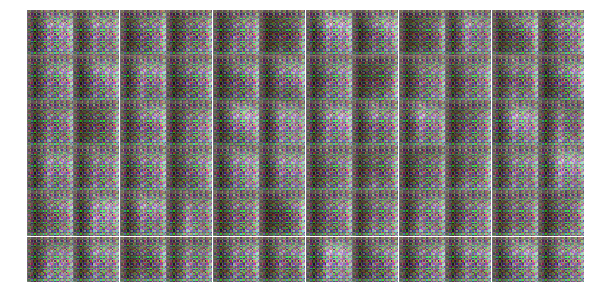

Epoch 1/25... Discriminator Loss: 0.1704... Generator Loss: 3.3405
Epoch 1/25... Discriminator Loss: 0.7233... Generator Loss: 2.2631
Epoch 1/25... Discriminator Loss: 0.9326... Generator Loss: 3.1614
Epoch 1/25... Discriminator Loss: 0.4213... Generator Loss: 1.7910
Epoch 1/25... Discriminator Loss: 0.3654... Generator Loss: 2.3805
Epoch 1/25... Discriminator Loss: 0.5272... Generator Loss: 1.4192
Epoch 1/25... Discriminator Loss: 0.2029... Generator Loss: 2.5242
Epoch 1/25... Discriminator Loss: 0.2564... Generator Loss: 4.3406
Epoch 1/25... Discriminator Loss: 0.3725... Generator Loss: 2.2245
Epoch 1/25... Discriminator Loss: 0.6831... Generator Loss: 1.3833


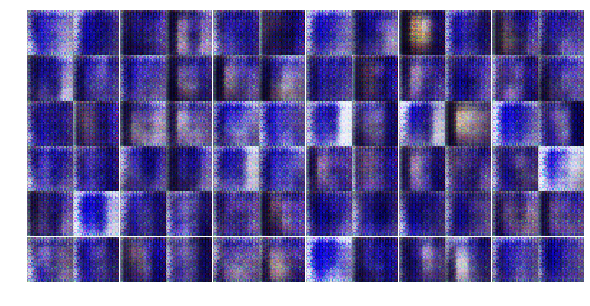

Epoch 1/25... Discriminator Loss: 0.5105... Generator Loss: 2.2586
Epoch 1/25... Discriminator Loss: 0.8305... Generator Loss: 3.4572
Epoch 1/25... Discriminator Loss: 1.9773... Generator Loss: 0.4773
Epoch 1/25... Discriminator Loss: 0.8501... Generator Loss: 0.8467
Epoch 1/25... Discriminator Loss: 0.2007... Generator Loss: 2.4055
Epoch 1/25... Discriminator Loss: 0.8926... Generator Loss: 1.2957
Epoch 1/25... Discriminator Loss: 0.6573... Generator Loss: 1.3665
Epoch 1/25... Discriminator Loss: 1.3910... Generator Loss: 0.9667
Epoch 1/25... Discriminator Loss: 1.2286... Generator Loss: 1.1469
Epoch 1/25... Discriminator Loss: 1.1298... Generator Loss: 1.2106


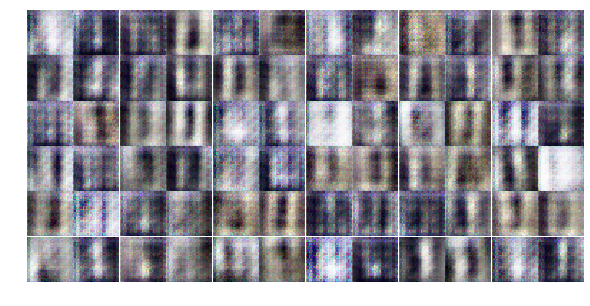

Epoch 1/25... Discriminator Loss: 0.8375... Generator Loss: 1.1074
Epoch 1/25... Discriminator Loss: 0.6165... Generator Loss: 2.2342
Epoch 1/25... Discriminator Loss: 0.6782... Generator Loss: 1.0087
Epoch 1/25... Discriminator Loss: 0.6506... Generator Loss: 1.4798
Epoch 1/25... Discriminator Loss: 0.8523... Generator Loss: 1.1825
Epoch 1/25... Discriminator Loss: 0.9284... Generator Loss: 0.9690
Epoch 1/25... Discriminator Loss: 0.5133... Generator Loss: 1.9714
Epoch 1/25... Discriminator Loss: 0.4468... Generator Loss: 2.2018
Epoch 1/25... Discriminator Loss: 0.6609... Generator Loss: 1.3721
Epoch 1/25... Discriminator Loss: 0.7700... Generator Loss: 1.3589


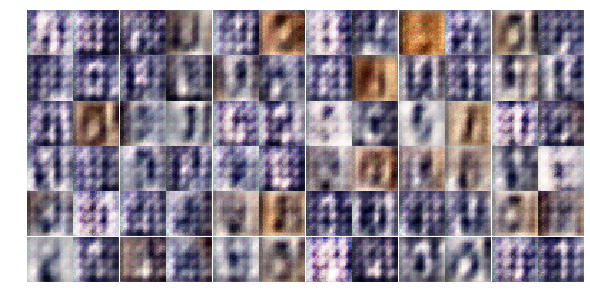

Epoch 1/25... Discriminator Loss: 0.9646... Generator Loss: 1.1300
Epoch 1/25... Discriminator Loss: 0.9802... Generator Loss: 1.0482
Epoch 1/25... Discriminator Loss: 0.8208... Generator Loss: 1.7102
Epoch 1/25... Discriminator Loss: 0.8023... Generator Loss: 2.0854
Epoch 1/25... Discriminator Loss: 0.9332... Generator Loss: 0.8620
Epoch 1/25... Discriminator Loss: 0.4833... Generator Loss: 2.0179
Epoch 1/25... Discriminator Loss: 0.7509... Generator Loss: 1.2133
Epoch 1/25... Discriminator Loss: 0.8542... Generator Loss: 1.0431
Epoch 1/25... Discriminator Loss: 1.0800... Generator Loss: 0.6832
Epoch 1/25... Discriminator Loss: 0.7524... Generator Loss: 1.8418


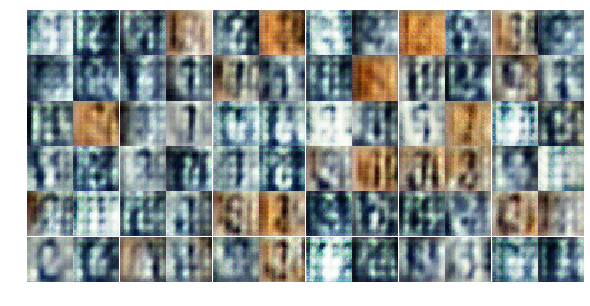

Epoch 1/25... Discriminator Loss: 0.7432... Generator Loss: 1.4084
Epoch 1/25... Discriminator Loss: 0.9183... Generator Loss: 1.1595
Epoch 1/25... Discriminator Loss: 0.8072... Generator Loss: 1.4811
Epoch 1/25... Discriminator Loss: 1.6330... Generator Loss: 0.3429
Epoch 1/25... Discriminator Loss: 1.1470... Generator Loss: 0.8603
Epoch 1/25... Discriminator Loss: 0.6450... Generator Loss: 1.5641
Epoch 1/25... Discriminator Loss: 0.8501... Generator Loss: 1.0692
Epoch 2/25... Discriminator Loss: 0.8180... Generator Loss: 1.3960
Epoch 2/25... Discriminator Loss: 0.8280... Generator Loss: 1.3814
Epoch 2/25... Discriminator Loss: 0.9399... Generator Loss: 0.7771


In [0]:
dataset = Dataset(trainset, testset)

losses, samples = train(net, dataset, epochs, batch_size, figsize=(10,5))

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
fig, ax = plt.subplots()
losses = np.array(losses)
plt.plot(losses.T[0], label='Discriminator', alpha=0.5)
plt.plot(losses.T[1], label='Generator', alpha=0.5)
plt.title("Training Losses")
plt.legend()

In [0]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))

In [0]:
_ = view_samples(-1, samples, 6, 12, figsize=(10,5))